In [1]:
# 1. System & Path Setup
import os
import sys
import random
import pickle

# Add project module path
if sys.platform == "win32":
    module_path = r"D:/protein-subcellular-localization-prediction/script"
else:
    module_path = "/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/script"

if module_path not in sys.path:
    sys.path.append(module_path)

# 2. Set Global Seed
SEED = 42
random.seed(SEED)

import numpy as np
import torch as T

np.random.seed(SEED)
T.manual_seed(SEED)
if T.cuda.is_available():
    T.cuda.manual_seed_all(SEED)

# 3. Standard Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 4. ML/Stats/Transformers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.metrics.pairwise import cosine_similarity

from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F

from transformers import (
    BertTokenizer, BertModel,
    EsmTokenizer, EsmModel,
    AlbertTokenizer, AlbertModel,
    XLNetTokenizer, XLNetModel
)

# 5. Captum Interpretability
from captum.attr import IntegratedGradients, Saliency

# 6. Project Modules
from script.config import (
    max_enc_length, data_path, pkl_path, classes, test_name
)
from script.pickle_data import get_data
from script.feature_extraction import process_sequences
from script.preprocessing import build_dictionary, summary_stats
from script.utils import truncate, data_shuffle
from script.attention_viz import build_secreted_heatmap
from script.embedding import (
    ProteinClassifier, ProteinDataset,
    PrecomputedEmbeddingDataset,
    train_classifier, compute_and_save_embeddings,
    experiment_esm_mlp_kfold, train_on_full_data_and_test_esm
)
from script.experiments import attention_analysis
from script.experiments import (
    experiment_lstm_no_attention,
    experiment_bilstm_no_attention,
    experiment_lstm_attention,
    experiment_cnn_lstm_no_attention,
    experiment_cnn_bilstm_attention
)


/cs/student/projects2/ml/2024/yihanli/bioinformatics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

# 1. Data Loading

We load .fasta raw data files to generate .pkl files, and create token dictionaries and encode sequences.

In [3]:
# Load training and testing data (if pickle files are missing, they will be generated from FASTA)
train_data, train_labels = get_data(train=True)
test_data, _ = get_data(train=False)

# Build token dictionaries and encode protein sequences
vocab, reverse_dict, sentence_lengths, enc_max_len, enc_sentences = build_dictionary(train_data)
test_vocab, test_reverse_dict, test_sentence_lengths, _, test_enc_sentences = build_dictionary(
    test_data, vocab=vocab, max_sent_len_=max_enc_length
)

print(f"Vocabulary size: {len(vocab)}")
print(f"Example reverse dictionary items: {list(reverse_dict.items())[:10]}")

Max sequence length (train): 13100
Total train sequences: 7458
Max sequence length (test): 1389
Total test sequences: 20
Vocabulary size: 25
Example reverse dictionary items: [(0, '<PAD>'), (1, '<OOV>'), (2, 'M'), (3, 'G'), (4, 'E'), (5, 'A'), (6, 'L'), (7, 'P'), (8, 'Q'), (9, 'R')]


# 2. Feature Extraction
We extract engineered numerical features to sequences before model training, which are numerical representations of protein properties that might improve classification:
- **Sequence Length**: Longer proteins might be membrane-bound or structual; shorter ones might be cytoplasmic
- **Global Amino Acid Composition**: Distribution of all 20 amino acids in the full sequence. Some organelle proteins have distinct compositions (e.g. mitochondrail proteins might be rich in certain residues).
- **Local Amino Acid Composition**: First 50 and last 50 amino acids might be important for localization signals.
- **Isoelectric Point & Molecular Weight**: Reflects charge and size, important for transmembrane vs. soluble proteins.
- **Sequence Motifs (N-terminal & C-terminal Signals)**: Certain organelles (e.g. mitochondria, nucleus) use signal peptides for protein targeting.
- **Hydrophobicity & Total Charge**: Hydrophobic proteins tend to be *secreted* or *membrane-bound* while Charged proteins are often *nuclear or mitochondrail*

(Other features: Signal peptides, Secondary structure, can be added)

In [4]:
train_features = process_sequences(train_data)
test_features = process_sequences(test_data)

# Save the extracted features as .npy files for future use
np.save(f"{pkl_path}/train_features.npy", train_features)
np.save(f"{pkl_path}/test_features.npy", test_features)

print(f"Train features shape: {train_features.shape}, Test features shape: {test_features.shape}")

Train features shape: (7458, 71), Test features shape: (20, 71)


# 3. EDA
1. Raw Sequence Data
- **`train_data`**: A list of **protein sequences** (strings) for training.  
  - **Ideal format**:  
    ```python
    ["MVLSPADKTNVKAA...", "MADQLTEEQIAEF...", ...]
    ```
- **`test_data`**: A list of **protein sequences** (strings) for testing, structured like `train_data`.

2. Labels
- **`train_labels`**: A **NumPy array** of integers representing the class labels for each training sequence.
  - **Ideal format**:  
    ```python
    [0, 1, 2, 3, 0, 2, ...]
    ```
  - **Label Mapping Example**:  
    ```python
    {0: "cytosolic", 1: "secreted", 2: "mitochondrial", 3: "nuclear"}
    ```

3. Encoded Sequences
- **`enc_sentences`**: A **NumPy array** of integer-encoded sequences (from `build_dictionary()`).  
  - **Ideal format**:  
    ```python
    [[2, 5, 1, 8, 3, 0, 0, 0], 
     [6, 9, 4, 7, 1, 1, 0, 0], 
     ...]
    ```
  - Padding (`<PAD>` = `0`) ensures all sequences have the same length.

4. Engineered Features
- **`train_features`**: A **NumPy array** of extracted numerical features for each training sequence.  
  - **Ideal format**:  
    ```python
    [[120.0, 0.05, 0.08, ..., 9.4, 13400], 
     [85.0, 0.07, 0.06, ..., 6.8, 9500], 
     ...]
    ```
  - **Feature columns**:
    1. Sequence length
    2. Global amino acid composition (20 values)
    3. Local composition (first/last 50 residues, 40 values total)
    4. Molecular properties (isoelectric point, molecular weight)
    5. Motif presence (binary indicators)

- **`test_features`**: Structured like `train_features`, but for testing data.

### EDA1: Histogram of Training & Testing Sequence Lengths.
- **Training Sequences**
    - Most training sequences are concentrated below 1000 residues, while peak frequency occurs around 250-500 residues. However, the training set contains some significantly longer sequences (~2000 residues)
- **Testing Sequences**
    - The test set has very few sequences over 1250 residues, meaning very long sequences may be underrepresented in testing.
- **Potential Data Distribution Mismatch**
    - If the test set contains mostly short sequences but the model was trained on a broader range, model might overfit longer sequences.
    - We could apply:
        - Padding & Truncation: Since sequence lengths vary widely, for deep learning models (e.g., CNN/RNN/Transformer), padding/truncation will be required to handle different sequence sizes.
        - Normalizing the sequence length feature (if it's strong)
        - Group sequences into *length-buckets* during training (for RNNs or Transformers)

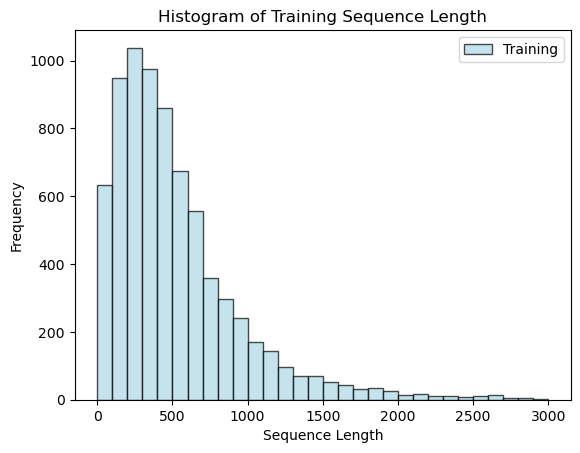

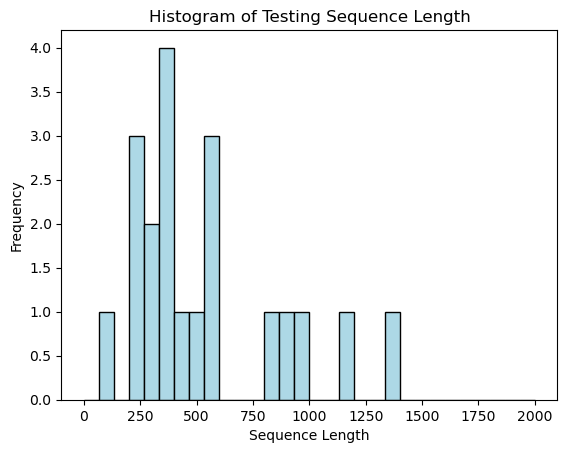

In [6]:
# EDA: Histogram of Sequence Lengths
# Histogram for training sequence lengths
plt.figure()
plt.hist(sentence_lengths, bins=30, range=(0, 3000), alpha=0.7,
         label="Training", color='lightblue', edgecolor='black')
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Histogram of Training Sequence Length")
plt.legend()
plt.show()

# Histogram for testing sequence lengths
plt.figure()
plt.hist(test_sentence_lengths, bins=30, range=(0, 2000), color='lightblue', edgecolor='black')
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Histogram of Testing Sequence Length")
plt.show()

### EDA2: Summary Statstics for Training Data.
- **Class Distribution by Lengths**: Cytosolic proteins (2463) most common, Nuclear (2736) also well represented, Secreted (1236) and mitochondrial (1023) less frequent.
- **Length Distribution**: Mean (537 residues), Range (11, 13,100)
    - Extreme length range means *padding/truncation* may be necessary
    - *Length-based feature extraction* maybe help improve classification as some protein classes ted to have shorter/longeer sequences
    

In [7]:
# EDA: Summary Statistics for Training Data
train_statistics, train_frame = summary_stats(sentence_lengths, np.array(train_labels), 'train')


~~~~~~~ Summary stats for train set ~~~~~~~

Count of sequence lengths by class
Class        cyto  secreted  mito  nucleus  Total
[0,100)        42       500    58       32    632
[100,500)    1143       530   744     1407   3824
[500,1000)    857       150   203      918   2128
[1000,1500)   274        23    14      240    551
[1500,2000)    84        17     2       84    187
[2000,2500)    33         8     1       22     64
[2500,inf]     30         8     1       33     72
Total        2463      1236  1023     2736   7458

Descriptive statistics
             length        label
count   7458.000000  7458.000000
mean     537.951327     1.540628
std      517.156951     1.281709
min       11.000000     0.000000
25%      225.000000     0.000000
50%      415.000000     2.000000
75%      684.000000     3.000000
max    13100.000000     3.000000


### EDA3: Feature Correlation Heatmap.
- **Class Distribution by Lengths**: 
    - Some global and local amino acid compositions show strong correlations.
    - Isoelectric point and molecular weight are weakly correlated with other features.
    - Diagonal patterns show redundancy in features -> PCA/Feature Selection.

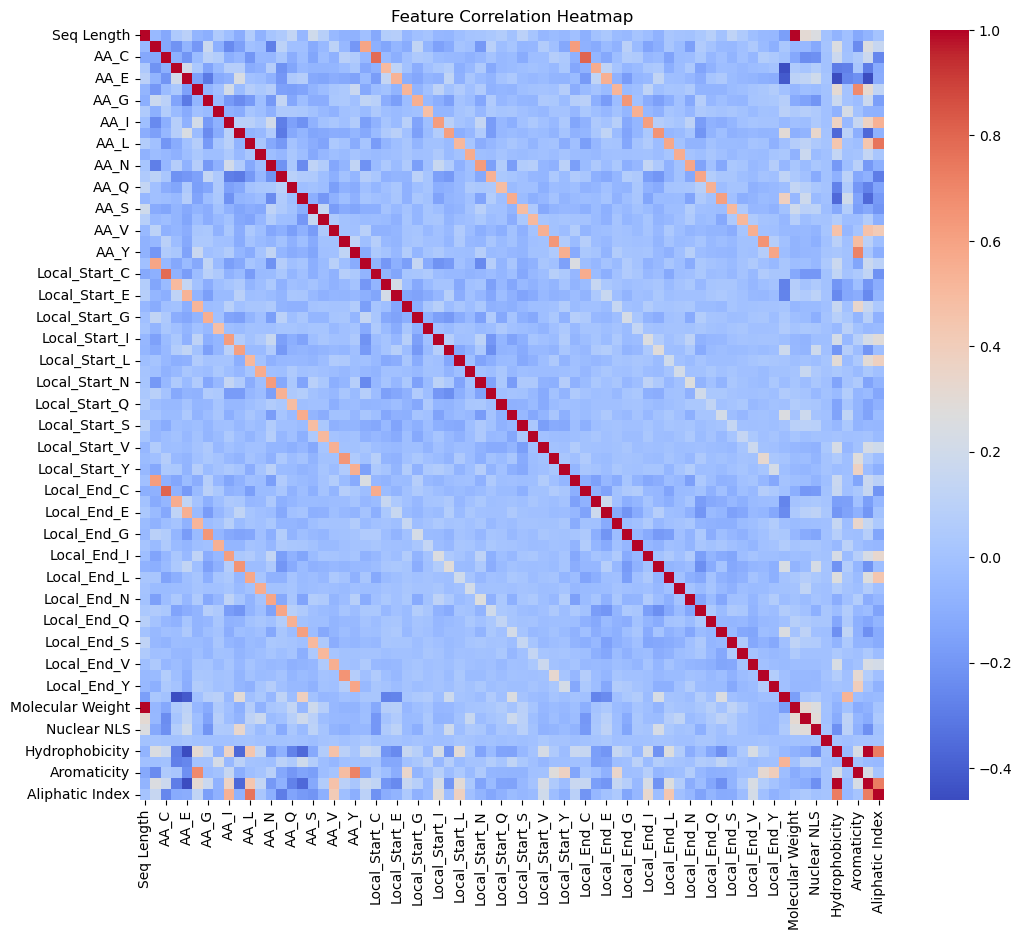

In [8]:
# EDA: Feature Correlation Heatmap
AA_LIST = "ACDEFGHIKLMNPQRSTVWY" 
# Define column names corresponding to the 71 extracted features
columns = (
    ["Seq Length"] +
    [f"AA_{aa}" for aa in AA_LIST] +
    [f"Local_Start_{aa}" for aa in AA_LIST] +
    [f"Local_End_{aa}" for aa in AA_LIST] +
    ["Isoelectric Point", "Molecular Weight", "Mito Motif", "Nuclear NLS", "ER Retention"] +
    ["Hydrophobicity", "Charge"] +
    ["Aromaticity", "GRAVY", "Aliphatic Index"]
)

train_features_df = pd.DataFrame(train_features, columns=columns)

plt.figure(figsize=(12, 10))
sns.heatmap(train_features_df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

### EDA4: Class-wise Feature Distributions (Isoelectric Point vs. Class)
- **Isoelectric point is a strong predictor because**:
    - Mitochondrail tend to have higher isoelectric points than especially cytosolic proteins.
    - A combination of physicochemical properties + sequence-based embeddings may improve classification accuracy.
    - Additional features are needed to distinguish between nuclear and cytosolic proteins.

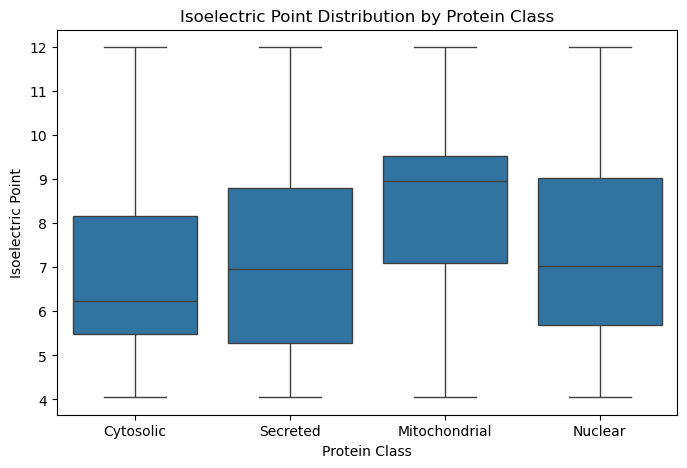

In [9]:
# EDA: Isoelectric Point Distribution by Protein Class
# Map numeric labels to class names
class_names = {0: "Cytosolic", 1: "Secreted", 2: "Mitochondrial", 3: "Nuclear"}
train_features_df['label'] = train_labels  # Assumes train_labels are numeric indices

plt.figure(figsize=(8, 5))
sns.boxplot(x=train_features_df['label'].map(class_names),
            y=train_features_df["Isoelectric Point"])
plt.xlabel("Protein Class")
plt.ylabel("Isoelectric Point")
plt.title("Isoelectric Point Distribution by Protein Class")
plt.show()

### EDA5: Motif Presence Across Classes
- Mito proteins have high occurence of mitochondrail motifs.
- NLS are strongly present in nuclear proteins.
- ER retention motifs are rare, indicating ER protins may be underrepresented.
- If specific classes heavily rely on motifs, **pattern-based models** (E.g.CNNs with motif detection layers) can be used.
- Motif-based **feature selection/embeddiing enhancement** e.g. integrating motif prob into the model may improve classification.

/tmp/ipykernel_90203/1680012793.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=motif_counts.index, y=motif_counts.values, palette="magma")


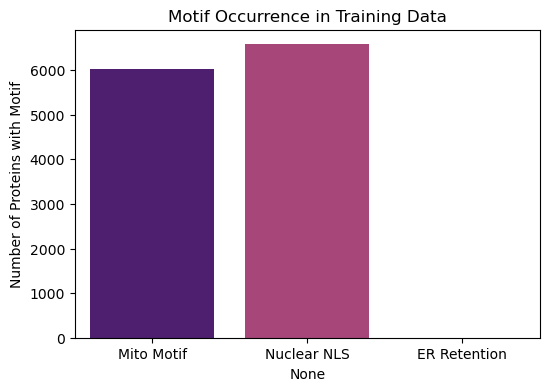

In [11]:
# EDA: Motif Occurrence in Training Data
motif_counts = train_features_df[["Mito Motif", "Nuclear NLS", "ER Retention"]].sum()

plt.figure(figsize=(6, 4))
sns.barplot(x=motif_counts.index, y=motif_counts.values, palette="magma")
plt.ylabel("Number of Proteins with Motif")
plt.title("Motif Occurrence in Training Data")
plt.show()

# 5. ML Model Implementation
Random Forest, XGBoost, SVM, LightGBM.

To do: 
- Fine-tune each model separately using CV + grid search
- Use PCA to reduce redundancy in amino acid composition features
- Use SHAP values or L1 to remove less relevant features

In [10]:
# Load Data
train_features = np.load("pkl/train_features.npy")
train_labels = np.load("pkl/train_labels.pkl", allow_pickle=True)

# Standardize Features (PCA is affected by scaling)
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)


# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, stratify=train_labels, random_state=42)

print(f"Original Feature Count: {train_features.shape[1]}")

Original Feature Count: 71


✅ Loading pre-trained SVM model...
Best model hyperparameters: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Accuracy: 0.6508
F1 Score: 0.6482
AUC: 0.7849

Classification Report:
               precision    recall  f1-score   support

    Cytosolic       0.59      0.57      0.58       493
     Secreted       0.72      0.85      0.78       247
Mitochondrial       0.58      0.75      0.65       205
      Nuclear       0.71      0.60      0.65       547

     accuracy                           0.65      1492
    macro avg       0.65      0.69      0.67      1492
 weighted avg       0.65      0.65      0.65      1492



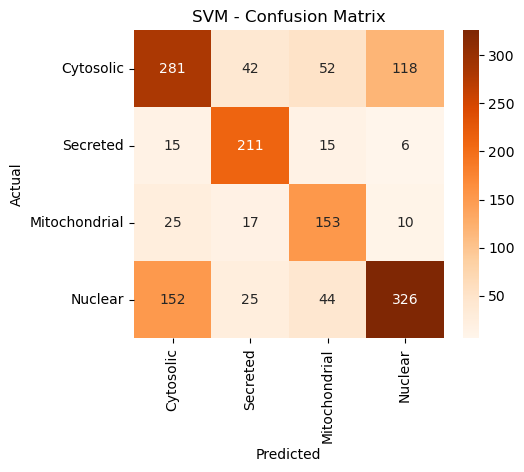

In [21]:
svm_model_path = "pkl/best_svm_model.pkl"

# Define SVM hyperparameter grid
svm_param_grid = {
    "C": [0.1, 1, 10],  # Regularization strength
    "gamma": ["scale", "auto", 0.01, 0.1, 1],  # Kernel coefficient
    "kernel": ["rbf"]  # Radial basis function (best for non-linear classification)
}

# Initialize SVM model
svm_model = SVC(probability=True, class_weight="balanced", random_state=42)

# Perform GridSearchCV with 5-Fold Stratified Cross-Validation
svm_grid_search = GridSearchCV(
    svm_model,
    param_grid=svm_param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

if os.path.exists(svm_model_path):
    print("✅ Loading pre-trained SVM model...")
    best_svm_model = joblib.load(svm_model_path)
else:
    print("🚀 Running Grid Search for SVM...")
    # Train the model with grid search
    svm_grid_search.fit(X_train, y_train)

    # Save the best model
    joblib.dump(svm_grid_search.best_estimator_, "pkl/best_svm_model.pkl")

# Evaluate on validation set
y_pred_svm = best_svm_model.predict(X_val)

# Print Results
print("Best model hyperparameters:", best_svm_model.get_params())
print(f"Accuracy: {accuracy_score(y_val, y_pred_svm):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_svm, average='weighted'):.4f}")
print(f"AUC: {roc_auc_score(pd.get_dummies(y_val), pd.get_dummies(y_pred_svm), multi_class='ovr'):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_svm, target_names=["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"]))

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_svm), annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"],
            yticklabels=["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM - Confusion Matrix")
plt.show()

# 7. DL Model Implementation

In [34]:
# A) Data Truncation & Shuffling
shuf_seq, shuf_label, shuf_len = data_shuffle(
    enc_sentences, np.array(train_labels), sentence_lengths, random_seed=SEED
)
enc_truncated, enc_trunc_len = truncate(shuf_seq, shuf_len, max_enc_length=2000)

In [ ]:
# B) Hyperparameter Tuning with Bayesian Optimization
def objective(trial):
    """
    Optuna objective function to tune hyperparameters for 'experiment_cnn_bilstm_attention.'
    Returns the best validation accuracy across epochs.
    """
    # 1) Suggest hyperparameter values
    hidden_size = trial.suggest_categorical("hidden_size", [128, 256, 512])
    embedding_size = trial.suggest_categorical("embedding_size", [32, 64, 128])
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    kernel_size = trial.suggest_categorical("kernel_size", [[3, 5, 7], [3, 5, 9], [3, 7, 11]])
    
    # 2) Run experiment with suggested hyperparams
    _, results = experiment_cnn_bilstm_attention(
        enc_truncated,
        enc_trunc_len,
        shuf_label,
        vocab,
        batch_size=96,
        output_size=4,
        hidden_size=hidden_size,
        embedding_size=embedding_size,
        kernel_size=kernel_size,
        num_epoch=32,
        lr=lr,
        if_attention=True,
        gra_clip=True,
        k_fold=5,
        fold_idx=1,
        save_model_path=None,  # Disable saving for speed
        random_seed=42,
        load_epoch=None
    )

    if results is None:
        return 0.0  # If something failed

    # 3) Extract best validation accuracy
    (TL1, Tacc1, VL1, Vacc1, count_matrix, y_true, y_pred, y_prob) = results
    best_val_acc = max(Vacc1)  # or Vacc1[-1] if you prefer final accuracy
    return best_val_acc

optuna.seed = 42
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print(f"Number of finished trials: {len(study.trials)}")
best_trial = study.best_trial
print(f"Best trial value: {best_trial.value}")
print("Best trial hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

## 7.1 vanilla LSTM

- `experiment_lstm_no_attention` (in **`experiments.py`**)
- `run()` Class (in **`trainer.py`**)
- `attentionLSTM` Class (in **`model_definitions.py`**)
- For epoch = 32, the training accuracy is high (~88%) but validation accuracy stagnates around 70%, suggesting overfitting.
- Validation loss stops decreasing around epoch 22-25, meaning further training doesn't help, so we decrease epoch to 25.
- To improve generalization, we modify the networking hyperparameters:
    - hidden_size: 128 -> 256 gives higher validation accuarcy and lower validation loss, but starts overfitting more aggresively after epoch 18, so less stable
    - batch size: 32 -> 64 (with 256) make it worse
    - dropout 0.03 -> val acc oscillates at epoch 5 already
    - learning rate 0.001 -> 0.0005 much lower val acc, sudden drop at epoch12
    - weight_decay 1e-4: lower val loss but val acc start dropping from epoch 15 and lower than without

[I 2025-03-15 11:35:39,282] Trial 9 finished with value: 72.82608795166016 and parameters: {'hidden_size': 256, 'embedding_size': 128, 'lr': 0.0004238078704764308}. Best is trial 9 with value: 72.82608795166016.
Number of finished trials: 10
Best trial:
  Value:  72.82608795166016
  Params: 
    hidden_size: 256
    embedding_size: 128
    lr: 0.0004238078704764308


In [ ]:
# 1) Vanilla LSTM (No Attention)
lstm_model, lstm_results = experiment_lstm_no_attention(
    enc_truncated,
    enc_trunc_len,
    shuf_label,
    vocab,
    reverse_dict,
    batch_size=32,
    hidden_size=256,
    embedding_size=128,
    num_epoch=100,
    lr=0.00042,
    kernel_size=None,
    bidirection=False,
    if_attention=False,
    gra_clip=True,
    k_fold=5,
    fold_idx=1,
    save_model_path=r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/dl_models/vanilla_lstm",
    random_seed=42
)
# Save model results (pickle)
lstm_save_path = os.path.join(r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/metrics", "lstm_results.pkl")
with open(lstm_save_path, 'wb') as f:
    pickle.dump(lstm_results, f)


## 7.2 Bi-LSTM

[I 2025-03-15 14:35:13,877] Trial 9 finished with value: 66.84782409667969 and parameters: {'hidden_size': 128, 'embedding_size': 32, 'lr': 0.0001175521774205785}. Best is trial 8 with value: 72.4184799194336.
Number of finished trials: 10
Best trial:
  Value:  72.4184799194336
  Params: 
    hidden_size: 256
    embedding_size: 128
    lr: 0.0002968147932418858


In [ ]:
# 2) BiLSTM (No Attention)
bilstm_model, bilstm_results = experiment_bilstm_no_attention(
    enc_truncated,
    enc_trunc_len,
    shuf_label,
    vocab,
    reverse_dict,
    batch_size=32,
    hidden_size=256,
    embedding_size=128,
    num_epoch=100,
    lr=0.00030,
    bidirection=True,
    if_attention=False,
    k_fold=5,
    fold_idx=1,
    save_model_path=r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/dl_models/bilstm",
    random_seed=SEED
)
bilstm_save_path = os.path.join(r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/metrics", "bilstm_results.pkl")
with open(bilstm_save_path, 'wb') as f:
    pickle.dump(bilstm_results, f)

## 7.3 LSTM + Attention

Trial 9 finished with value: 69.70108795166016 and parameters: {'hidden_size': 128, 'embedding_size': 32, 'lr': 0.007303869379925937, 'bidirection': False}. Best is trial 8 with value: 71.875.
Number of finished trials: 10
Best trial:
  Value:  71.875
  Params: 
    hidden_size: 512
    embedding_size: 64
    lr: 0.0003181738672838716
    bidirection: True


In [ ]:
# 3) LSTM + Attention
lstm_att_model, lstm_att_results = experiment_lstm_attention(
    enc_truncated,
    enc_trunc_len,
    shuf_label,
    vocab,
    reverse_dict,
    batch_size=32,
    hidden_size=512,
    embedding_size=64,
    num_epoch=100,
    lr=0.00032,
    bidirection=True,
    if_attention=True,
    k_fold=5,
    fold_idx=1,
    save_model_path=r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/dl_models/attlstm",
    random_seed=SEED
)
attlstm_save_path = os.path.join(r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/metrics", "attlstm_results.pkl")
with open(attlstm_save_path, 'wb') as f:
    pickle.dump(lstm_att_results, f)

## 7.4 LSTM + CNN

[I 2025-03-15 16:05:14,465] Trial 9 finished with value: 69.79167175292969 and parameters: {'hidden_size': 64, 'embedding_size': 32, 'lr': 0.00024577443866648214, 'kernel_size': [3, 5, 7]}. Best is trial 2 with value: 70.97222900390625.
Number of finished trials: 10
Best trial:
  Value:  70.97222900390625
  Params: 
    hidden_size: 512
    embedding_size: 128
    lr: 0.0004204919251196771
    kernel_size: [3, 5, 7]


In [ ]:
# 4) CNN + LSTM (No Attention)
cnn_lstm_model, cnn_lstm_results = experiment_cnn_lstm_no_attention(
    enc_truncated,
    enc_trunc_len,
    shuf_label,
    vocab,
    batch_size=96,
    hidden_size=512,
    embedding_size=128,
    kernel_size=[3, 5, 7],
    num_epoch=100,
    lr=0.00042,
    bidirection=False,
    if_attention=False,
    k_fold=5,
    fold_idx=1,
    save_model_path=r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/dl_models/cnnlstm",
    random_seed=SEED
)
cnnlstm_save_path = os.path.join(r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/metrics", "cnnlstm_results.pkl")
with open(cnnlstm_save_path, 'wb') as f:
    pickle.dump(cnn_lstm_results, f)


## 7.5 BiLSTM + Attention + CNN


[I 2025-03-15 16:40:58,467] Trial 4 finished with value: 70.90278625488281 and parameters: {'hidden_size': 256, 'embedding_size': 128, 'lr': 0.0001854853097257069, 'kernel_size': [3, 5, 9]}.

In [ ]:
# 5) CNN + BiLSTM + Attention
cnn_bilstm_model, cnn_bilstm_att_results = experiment_cnn_bilstm_attention(
    enc_truncated,
    enc_trunc_len,
    shuf_label,
    vocab,
    batch_size=96,
    output_size=4,
    hidden_size=256,
    embedding_size=128,
    kernel_size=[3, 5, 9],
    num_epoch=100,
    lr=0.000185,
    if_attention=True,
    gra_clip=True,
    k_fold=5,
    fold_idx=1,
    save_model_path=r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/dl_models/cnn_bilstm_att",
    random_seed=42
)
cnn_bilstm_save_path = os.path.join(r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/metrics", "cnn_bilstm_att_results.pkl")
with open(cnn_bilstm_save_path, 'wb') as f:
    pickle.dump(cnn_bilstm_att_results, f)

## 7.6 ProtBert Embedding + Classifier (MLP)

In [4]:
# Load ProtBert tokenizer and model
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
pretrained_model = BertModel.from_pretrained("Rostlab/prot_bert")

# Create dataset
dataset = ProteinDataset(train_data, train_labels, tokenizer, max_length=2000)

# ----- Split Data into Training and Validation -----
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training samples: {train_size}, Validation samples: {val_size}")

# Compute Sequence Embeddings Once
if not os.path.exists("train_embeddings_protbert.pt"):
    print("Computing embeddings for the training set...")
    compute_and_save_embeddings(train_dataset, pretrained_model, tokenizer, batch_size=32, save_path="train_embeddings.pt")

if not os.path.exists("val_embeddings_protbert.pt"):
    print("Computing embeddings for the validation set...")
    compute_and_save_embeddings(val_dataset, pretrained_model, tokenizer, batch_size=32, save_path="val_embeddings.pt")
    

# Use the precomputed data instead of tokenizing again
# Load precomputed embeddings
train_dataset = PrecomputedEmbeddingDataset("train_embeddings_protbert.pt")
val_dataset = PrecomputedEmbeddingDataset("val_embeddings_protbert.pt")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
device = "cuda" if T.cuda.is_available() else "cpu"
model = ProteinClassifier(embedding_size = 1024, num_classes=4)
model.to(device)

# Train the model
protbert_model, protbert_results = train_classifier(model, train_loader, val_loader, num_epochs=100, lr=0.002, device=device)

protbert_save_path = os.path.join(r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/metrics", "protbert_results.pkl")

with open(protbert_save_path, 'wb') as f:
    pickle.dump(protbert_results, f)

Training samples: 5966, Validation samples: 1492


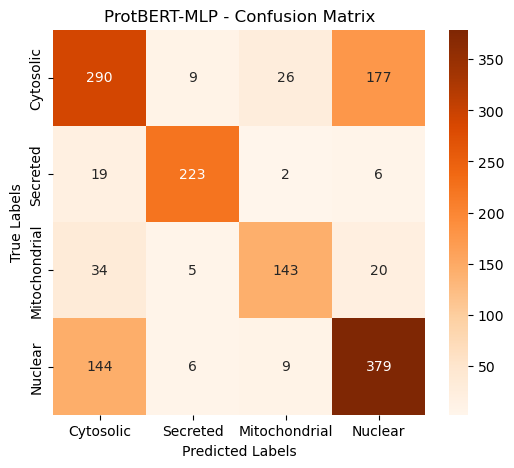

In [11]:
(train_losses, train_accuracies, val_losses, val_accuracies, count_matrix, y_true_final, y_pred_final, y_prob_final) = protbert_results

# Compute confusion matrix if needed
count_matrix = confusion_matrix(y_true_final, y_pred_final, labels=np.arange(4))
# Compute confusion matrix if needed
count_matrix = count_matrix / 100  # Take the mean over 100 epochs
count_matrix = np.round(count_matrix).astype(int)  # Round and convert to integer counts

# Define class names
class_labels = ["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"]

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(count_matrix, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("ProtBERT-MLP - Confusion Matrix")
plt.show()

## 7.7 ESM-2 Embedding + Classifier (MLP)

In [14]:
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
pretrained_model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

# Create dataset
dataset = ProteinDataset(train_data, train_labels, tokenizer, max_length=2000)

# ----- Split Data into Training and Validation -----
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {train_size}, Validation samples: {val_size}")

# Compute Sequence Embeddings Once
if not os.path.exists("train_embeddings_esm.pt"):
    print("Computing embeddings for the training set...")
    compute_and_save_embeddings(train_dataset, pretrained_model, tokenizer, batch_size=16,save_path="train_embeddings_esm.pt")

if not os.path.exists("val_embeddings_esm.pt"):
    print("Computing embeddings for the validation set...")
    compute_and_save_embeddings(val_dataset, pretrained_model, tokenizer, batch_size=16, save_path="val_embeddings_esm.pt")

# Load precomputed embeddings
train_dataset = PrecomputedEmbeddingDataset("train_embeddings_esm.pt")
val_dataset = PrecomputedEmbeddingDataset("val_embeddings_esm.pt")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
device = "cuda" if T.cuda.is_available() else "cpu"
model = ProteinClassifier(embedding_size = 320, num_classes=4)
model.to(device)

# Train the model
esm_model, esm_results = train_classifier(model, train_loader, val_loader, num_epochs=100, lr=0.002, device=device)

esm_save_path = os.path.join(r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/metrics", "esm_results.pkl")

with open(esm_save_path, 'wb') as f:
    pickle.dump(esm_results, f)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training samples: 5966, Validation samples: 1492


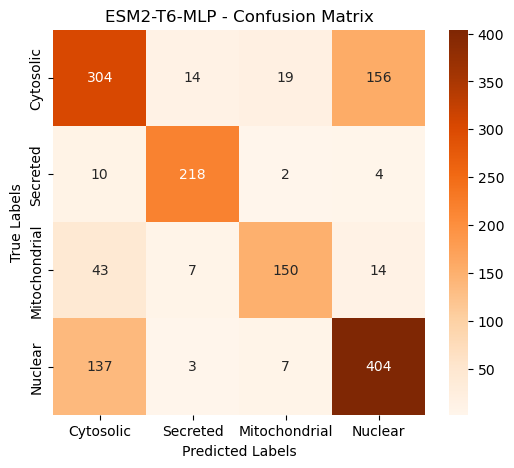

In [14]:
(train_losses, train_accuracies, val_losses, val_accuracies, count_matrix, y_true_final, y_pred_final, y_prob_final) = esm_results

# Compute confusion matrix if needed
count_matrix = confusion_matrix(y_true_final, y_pred_final, labels=np.arange(4))
# Compute confusion matrix if needed
count_matrix = count_matrix / 100  # Take the mean over 100 epochs
count_matrix = np.round(count_matrix).astype(int)  # Round and convert to integer counts

# Define class names
class_labels = ["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"]

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(count_matrix, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("ESM2-T6-MLP - Confusion Matrix")
plt.show()

## 7.8 ESM2 (Larger Variants) + MLP

In [4]:
################################################################################
# ESM2 (Alternate Larger Model： 1280 Embedding Dim + 650M params)
################################################################################
# 1) Choose the bigger checkpoint
model_name = "facebook/esm2_t33_650M_UR50D" 
tokenizer = EsmTokenizer.from_pretrained(model_name)
pretrained_model = EsmModel.from_pretrained(model_name)

# 2) Check hidden dim
hidden_size = pretrained_model.config.hidden_size
print("ESM2 hidden_size =", hidden_size)

# 3) Dataset + Split
dataset = ProteinDataset(train_data, train_labels, tokenizer, max_length=2000)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 4) Precompute embeddings
if not os.path.exists("train_embeddings_esm2large.pt"):
    compute_and_save_embeddings(train_dataset, pretrained_model, tokenizer, batch_size=4,
                                save_path="train_embeddings_esm2large.pt",
                                pooling_mode="cls")

if not os.path.exists("val_embeddings_esm2large.pt"):
    compute_and_save_embeddings(val_dataset, pretrained_model, tokenizer, batch_size=4,
                                save_path="val_embeddings_esm2large.pt",
                                pooling_mode="cls")
# 5) Load embeddings
train_dataset_emb = PrecomputedEmbeddingDataset("train_embeddings_esm2large.pt")
val_dataset_emb = PrecomputedEmbeddingDataset("val_embeddings_esm2large.pt")

train_loader = DataLoader(train_dataset_emb, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_emb, batch_size=32, shuffle=False)

# 6) MLP
device = "cuda" if T.cuda.is_available() else "cpu"
model = ProteinClassifier(embedding_size=hidden_size, num_classes=4).to(device)

# 7) Train
trained_model, results = train_classifier(model, train_loader, val_loader,
                                          num_epochs=100, lr=0.002, device=device)

with open("esm2large_results.pkl", "wb") as f:
    pickle.dump(results, f)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM2 hidden_size = 1280


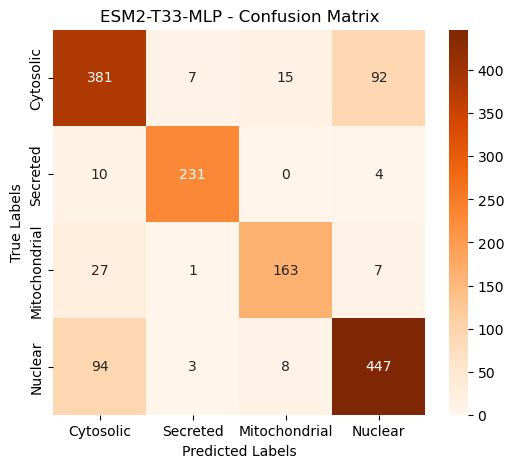

In [17]:
(train_losses, train_accuracies, val_losses, val_accuracies, count_matrix, y_true_final, y_pred_final, y_prob_final) = esm_large_results

# Compute confusion matrix if needed
count_matrix = confusion_matrix(y_true_final, y_pred_final, labels=np.arange(4))
# Compute confusion matrix if needed
count_matrix = count_matrix / 100  # Take the mean over 100 epochs
count_matrix = np.round(count_matrix).astype(int)  # Round and convert to integer counts

# Define class names
class_labels = ["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"]

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(count_matrix, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("ESM2-T33-MLP - Confusion Matrix")
plt.show()

## 7.8 ProtT5 Embedding + Classifier (MLP)
Model too large, due to：

- Long sequence length (max_length=2000) 
- T5 is highly memory-intensive for long sequences.
- Large model size (prot_t5_xl_bfd)
- This is an XL variant, which is too large for many GPUs.
- Attention mechanism complexity 
- T5 uses full self-attention, which scales quadratically with sequence length.

## 7.9 ProtXLNet Embedding + Classifier (MLP)

In [ ]:
################################################################################
# ProtXLNet
################################################################################


# 1) Load tokenizer/model
cache_dir = "/cs/student/projects2/ml/2024/yihanli/hf_cache"
tokenizer = XLNetTokenizer.from_pretrained("Rostlab/prot_xlnet", cache_dir=cache_dir, force_download=True)
pretrained_model = XLNetModel.from_pretrained("Rostlab/prot_xlnet", cache_dir=cache_dir, force_download=True)

# 2) Create dataset
dataset = ProteinDataset(train_data, train_labels, tokenizer, max_length=2000)

# 3) Train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 4) Precompute embeddings (pooling_mode="mean" recommended)
if not os.path.exists("train_embeddings_xlnet.pt"):
    compute_and_save_embeddings(train_dataset, pretrained_model, tokenizer, batch_size=4,
                                save_path="train_embeddings_xlnet.pt",
                                pooling_mode="mean")

if not os.path.exists("val_embeddings_xlnet.pt"):
    compute_and_save_embeddings(val_dataset, pretrained_model, tokenizer, batch_size=4,
                                save_path="val_embeddings_xlnet.pt",
                                pooling_mode="mean")

# 5) Load embeddings
train_dataset_emb = PrecomputedEmbeddingDataset("train_embeddings_xlnet.pt")
val_dataset_emb = PrecomputedEmbeddingDataset("val_embeddings_xlnet.pt")

train_loader = DataLoader(train_dataset_emb, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_emb, batch_size=32, shuffle=False)

# 6) MLP
device = "cuda" if T.cuda.is_available() else "cpu"
model = ProteinClassifier(embedding_size=1024, num_classes=4).to(device)

# 7) Train
trained_model, results = train_classifier(model, train_loader, val_loader,
                                          num_epochs=100, lr=0.002, device=device)
with open("prot_xlnet_results.pkl", "wb") as f:
    pickle.dump(results, f)

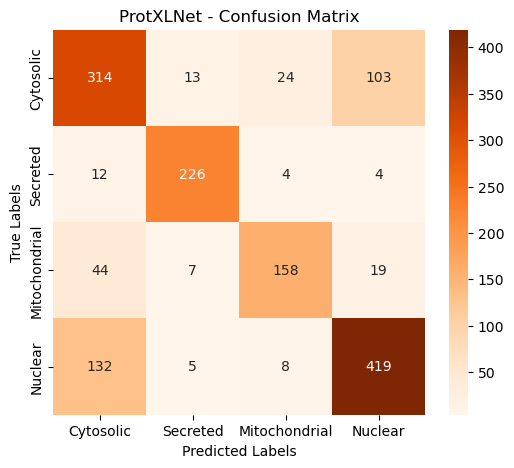

In [19]:
(train_losses, train_accuracies, val_losses, val_accuracies, count_matrix, y_true_final, y_pred_final, y_prob_final) = xlnet_results

# Compute confusion matrix if needed
count_matrix = confusion_matrix(y_true_final, y_pred_final, labels=np.arange(4))
# Compute confusion matrix if needed
count_matrix = count_matrix / 100  # Take the mean over 100 epochs
count_matrix = np.round(count_matrix).astype(int)  # Round and convert to integer counts

# Define class names
class_labels = ["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"]

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(count_matrix, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("ProtXLNet - Confusion Matrix")
plt.show()

## 7.10 ProtAlbert Embedding + Classifier (MLP)

In [ ]:
################################################################################
# ProtAlbert
################################################################################

# 1) Load tokenizer/model
tokenizer = AlbertTokenizer.from_pretrained("Rostlab/prot_albert", do_lower_case=False)
pretrained_model = AlbertModel.from_pretrained("Rostlab/prot_albert")

# Check hidden dimension in model.config.hidden_size
print("Hidden size:", pretrained_model.config.hidden_size)
# Suppose it's 4096 (confirm via model.config or HF docs)
albert_hidden_size = pretrained_model.config.hidden_size

# 2) Create dataset
dataset = ProteinDataset(train_data, train_labels, tokenizer, max_length=2000)

# 3) Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 4) Precompute embeddings (use "cls" for BERT-like)
if not os.path.exists("train_embeddings_albert.pt"):
    compute_and_save_embeddings(train_dataset, pretrained_model, tokenizer,
                                save_path="train_embeddings_albert.pt",
                                pooling_mode="cls")

if not os.path.exists("val_embeddings_albert.pt"):
    compute_and_save_embeddings(val_dataset, pretrained_model, tokenizer,
                                save_path="val_embeddings_albert.pt",
                                pooling_mode="cls")
# 5) Load embeddings
train_dataset_emb = PrecomputedEmbeddingDataset("train_embeddings_albert.pt")
val_dataset_emb = PrecomputedEmbeddingDataset("val_embeddings_albert.pt")

train_loader = DataLoader(train_dataset_emb, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_emb, batch_size=32, shuffle=False)

# 6) Classifier
device = "cuda" if T.cuda.is_available() else "cpu"
model = ProteinClassifier(embedding_size=albert_hidden_size, num_classes=4).to(device)

# 7) Train
trained_model, results = train_classifier(model, train_loader, val_loader,
                                          num_epochs=100, lr=0.002, device=device)
with open("prot_albert_results.pkl", "wb") as f:
    pickle.dump(results, f)

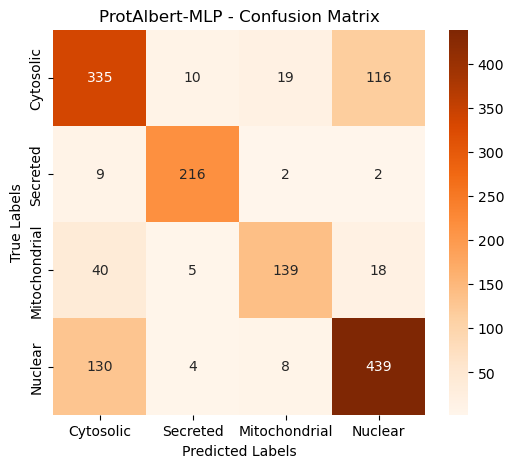

In [22]:
(train_losses, train_accuracies, val_losses, val_accuracies, count_matrix, y_true_final, y_pred_final, y_prob_final) = albert_results

# Compute confusion matrix if needed
count_matrix = confusion_matrix(y_true_final, y_pred_final, labels=np.arange(4))
# Compute confusion matrix if needed
count_matrix = count_matrix / 100  # Take the mean over 100 epochs
count_matrix = np.round(count_matrix).astype(int)  # Round and convert to integer counts

# Define class names
class_labels = ["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"]

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(count_matrix, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("ProtAlbert-MLP - Confusion Matrix")
plt.show()

## 7.5 Best Model Choosing
### Training/Validation Curve

In [14]:
# 1. Helper Functions
def load_result(result_path):
    """Helper function to load a pickled result."""
    with open(result_path, 'rb') as f:
        return pickle.load(f)

def to_numpy_list(lst):
    """Convert list of tensors to list of numpy arrays."""
    if isinstance(lst, list):
        return [t.cpu().numpy() if isinstance(t, T.Tensor) else np.array(t) for t in lst]
    return lst

def extract_metrics(results):
    """
    Extract training and validation metrics from a result tuple.
    Handles both 4-element (loss and accuracy only) and 8-element results.
    Returns a dictionary with keys: 'train_loss', 'train_acc', 'valid_loss', 'valid_acc', and 'epochs'.
    """
    if len(results) == 4:
        train_loss, train_acc, valid_loss, valid_acc = results
    else:
        # Ignore extra outputs (e.g. confusion matrix and predictions)
        train_loss, train_acc, valid_loss, valid_acc, _, _, _, _ = results
    metrics = {
        "train_loss": to_numpy_list(train_loss),
        "train_acc": to_numpy_list(train_acc),
        "valid_loss": to_numpy_list(valid_loss),
        "valid_acc": to_numpy_list(valid_acc),
        "epochs": list(range(1, len(train_loss) + 1))
    }
    return metrics

def smooth_curve(data, window_size=5):
    """Apply a moving average smoothing to a 1D array."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_confusion_matrix(cm, class_labels, title):
    """Plot a confusion matrix with given class labels and title."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

In [15]:
# 2. Load All Model Results
results_dir = r"/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/metrics"
# Dictionary mapping model keys to their result file names
result_files = {
    "lstm": "lstm_results.pkl",
    "bilstm": "bilstm_results.pkl",
    "lstm_att": "attlstm_results.pkl",
    "lstm_cnn": "cnnlstm_results.pkl",
    "lstm_total": "cnn-bilstm_att_results.pkl",
    "protbert": "protbert_results.pkl",
    "esm": "esm_results.pkl",
    "esmlarge": "esm2large_results.pkl",
    "protxlnet": "prot_xlnet_results.pkl",
    "albert": "prot_albert_results.pkl"
}

model_results = {}
for key, filename in result_files.items():
    path = os.path.join(results_dir, filename)
    if os.path.exists(path):
        model_results[key] = load_result(path)
    else:
        print(f"⚠️ Warning: {path} not found, skipping {key}.")


In [16]:
# 3. Extract Metrics for Plotting
# Human-readable labels for models
model_labels = {
    "lstm": "Vanilla LSTM",
    "bilstm": "BiLSTM",
    "lstm_att": "LSTM + Attention",
    "lstm_cnn": "LSTM-CNN",
    "lstm_total": "BiLSTM-CNN + Attention",
    "protbert": "ProtBERT",
    "esm": "ESM2-T6",
    "protxlnet": "ProtXLNet",
    "albert": "ProtAlbert",
    "esmlarge": "ESM2-T33"
}

# Extract per-model metrics into a new dictionary for easy plotting
model_metrics = {}
for model_name, results in model_results.items():
    metrics = extract_metrics(results)
    model_metrics[model_name] = metrics

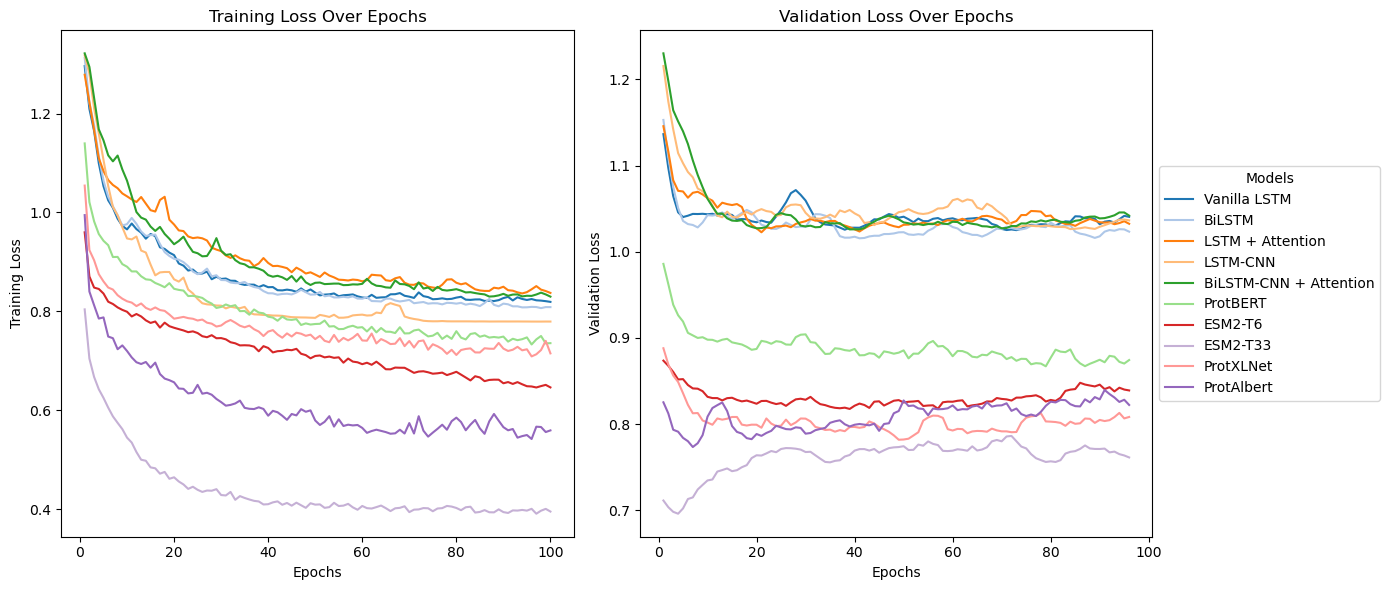

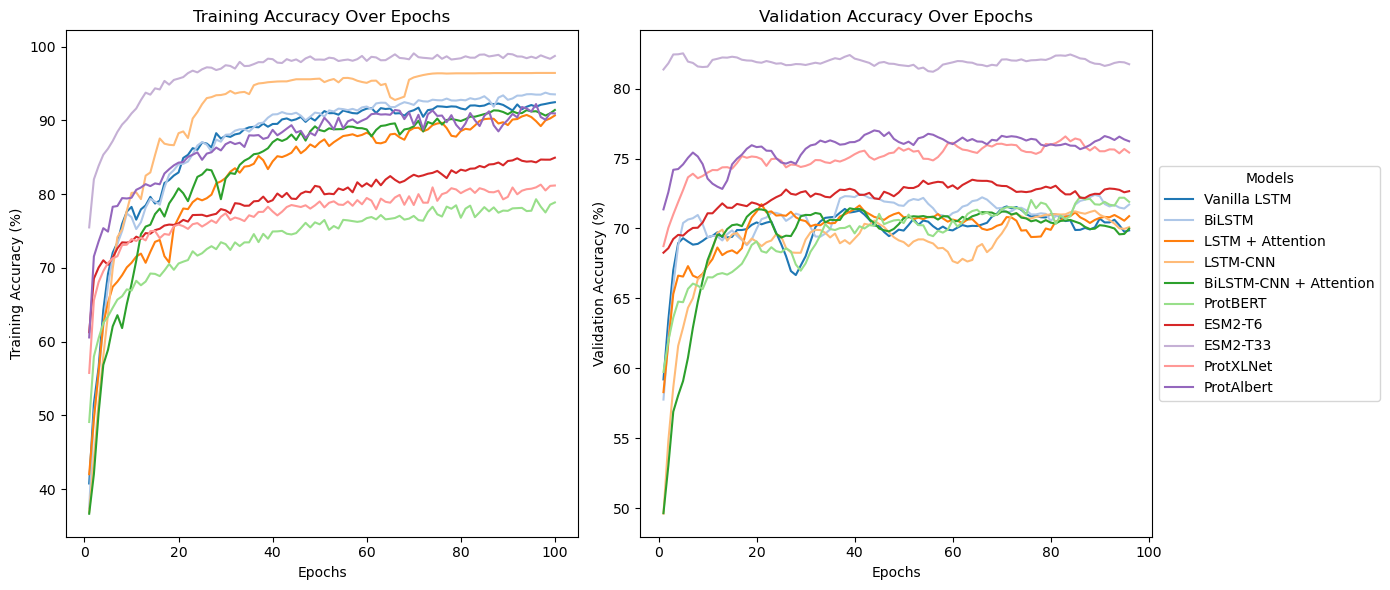

In [17]:
# 4. Plot Loss and Accuracy Curves
# Generate colors for each model
cmap = plt.get_cmap("tab20")
model_colors = {model: cmap(i % cmap.N) for i, model in enumerate(model_labels.keys())}

# Plot Training & Validation Loss
plt.figure(figsize=(14, 6))
# Training Loss
plt.subplot(1, 2, 1)
for model, metrics in model_metrics.items():
    plt.plot(metrics["epochs"], metrics["train_loss"], label=model_labels[model],
             color=model_colors[model])
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")

# Validation Loss (smoothed)
plt.subplot(1, 2, 2)
for model, metrics in model_metrics.items():
    smoothed_loss = smooth_curve(metrics["valid_loss"], window_size=5)
    plt.plot(metrics["epochs"][:len(smoothed_loss)], smoothed_loss, label=model_labels[model],
             color=model_colors[model])
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10, title="Models")
plt.tight_layout()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(14, 6))
# Training Accuracy
plt.subplot(1, 2, 1)
for model, metrics in model_metrics.items():
    plt.plot(metrics["epochs"], metrics["train_acc"], label=model_labels[model],
             color=model_colors[model])
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy (%)")
plt.title("Training Accuracy Over Epochs")

# Validation Accuracy (smoothed)
plt.subplot(1, 2, 2)
for model, metrics in model_metrics.items():
    smoothed_acc = smooth_curve(metrics["valid_acc"], window_size=5)
    plt.plot(metrics["epochs"][:len(smoothed_acc)], smoothed_acc, label=model_labels[model],
             color=model_colors[model])
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Over Epochs")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10, title="Models")
plt.tight_layout()
plt.show()

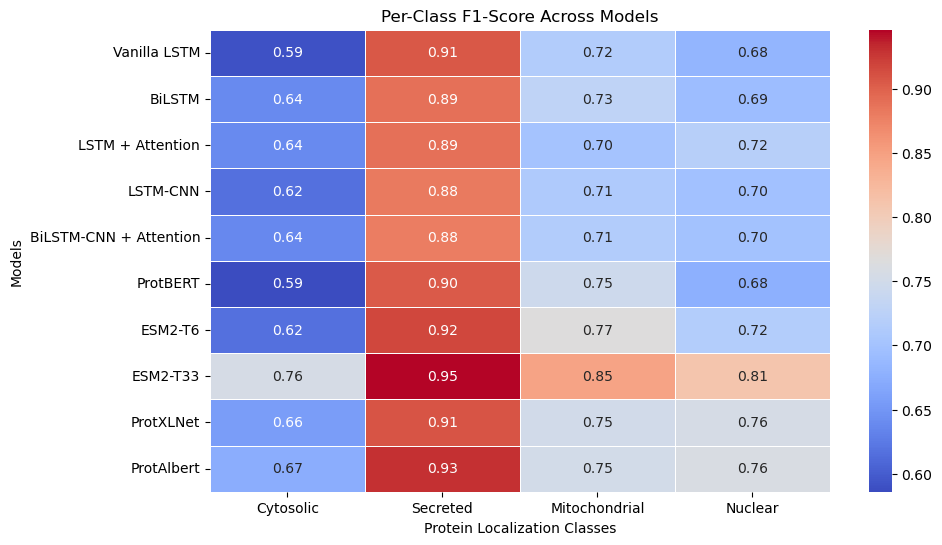

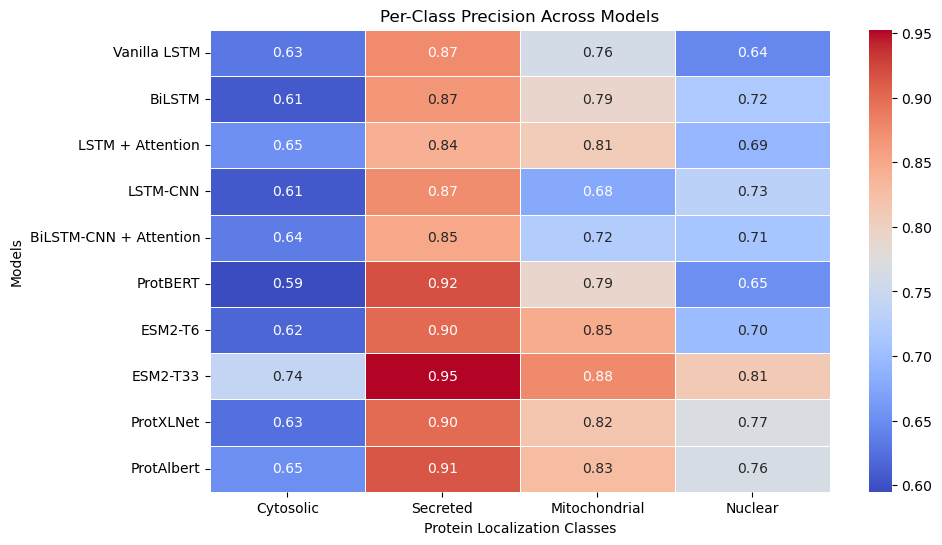

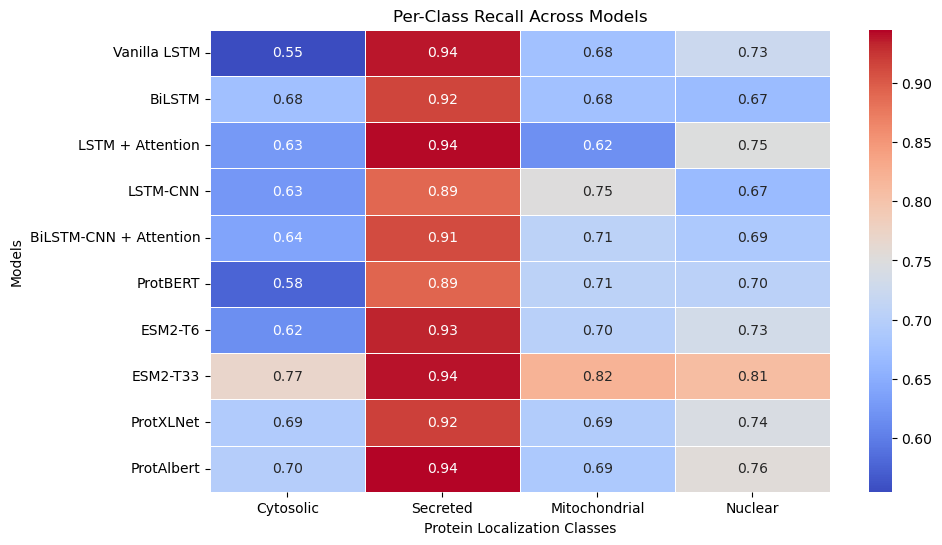

In [18]:
# 5. Compute Per-Class Metrics (Precision, Recall, F1)
# Initialize dictionaries to store per-class scores
model_classwise_f1 = {}
model_classwise_precision = {}
model_classwise_recall = {}
num_classes = 4

for key, results in model_results.items():
    # Use standard result tuple (assumes 8 elements)
    if len(results) == 4:
        # If no predictions available, skip
        continue
    else:
        _, _, _, _, _, y_true, y_pred, _ = results
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=np.arange(num_classes)
    )
    readable_name = model_labels.get(key, key)
    model_classwise_f1[readable_name] = f1
    model_classwise_precision[readable_name] = precision
    model_classwise_recall[readable_name] = recall

# Convert dictionaries to DataFrames for heatmaps
class_names = ["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"]
df_f1 = pd.DataFrame.from_dict(model_classwise_f1, orient="index", columns=class_names)
df_precision = pd.DataFrame.from_dict(model_classwise_precision, orient="index", columns=class_names)
df_recall = pd.DataFrame.from_dict(model_classwise_recall, orient="index", columns=class_names)

def plot_heatmap(df, metric_name, cmap="coolwarm"):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap=cmap, fmt=".2f", linewidths=0.5)
    plt.xlabel("Protein Localization Classes")
    plt.ylabel("Models")
    plt.title(f"Per-Class {metric_name} Across Models")
    plt.show()

plot_heatmap(df_f1, "F1-Score")
plot_heatmap(df_precision, "Precision")
plot_heatmap(df_recall, "Recall")

### Numerical Metrics
F1 score, Accuracy, Precision/Recall per Class, ROC_AUC, CE Loss.

In [21]:
# 6. Overall Model Performance Summary
model_names_list = ["lstm", "bilstm", "attlstm", "cnnlstm", "cnn-bilstm_att",
                    "protbert", "esm", "prot_xlnet", "prot_albert", "esm2large"]

metrics_dict = {"Model": [], "Macro-F1": [], "Accuracy": [], "ROC-AUC": [], "Precision": [], "Recall": [], "Loss": []}
for model in model_names_list:
    model_path = os.path.join(results_dir, f"{model}_results.pkl")
    if not os.path.exists(model_path):
        print(f"⚠️ Warning: {model_path} not found, skipping...")
        continue
    res = load_result(model_path)
    # Use standard results (assume 8-element tuple)
    if len(res) < 8:
        continue
    _, _, valid_loss, valid_acc, _, y_true, y_pred, y_prob = res
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    precision_avg, recall_avg, _, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_prob, multi_class="ovr") if y_prob is not None else None
    loss = valid_loss[-1] if not isinstance(valid_loss[-1], T.Tensor) else valid_loss[-1].cpu().item()
    
    metrics_dict["Model"].append(model_labels.get(model, model))
    metrics_dict["Macro-F1"].append(macro_f1)
    metrics_dict["Accuracy"].append(accuracy)
    metrics_dict["ROC-AUC"].append(roc_auc)
    metrics_dict["Precision"].append(precision_avg)
    metrics_dict["Recall"].append(recall_avg)
    metrics_dict["Loss"].append(loss)

metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Model,Macro-F1,Accuracy,ROC-AUC,Precision,Recall,Loss
0,Vanilla LSTM,0.723564,0.700408,0.861505,0.727869,0.723504,1.039973
1,BiLSTM,0.737582,0.715353,0.869766,0.745476,0.733665,1.025503
2,attlstm,0.737179,0.723505,0.855280,0.748988,0.733801,1.019528
3,cnnlstm,0.726931,0.706250,0.877690,0.722128,0.733586,1.032968
4,cnn-bilstm_att,0.732447,0.714583,0.851442,0.729643,0.735904,1.026556
5,ProtBERT,0.728327,0.693150,0.889044,0.738749,0.719783,0.886369
6,ESM2-T6,0.754182,0.721964,0.906778,0.765617,0.746462,0.829461
7,prot_xlnet,0.768041,0.748847,0.922974,0.777854,0.761715,0.808748
8,prot_albert,0.778476,0.756468,0.919945,0.789532,0.771164,0.839302
9,esm2large,0.839759,0.818733,0.937552,0.845631,0.834478,0.757435


## 7.6 Best Model Cross Validation (5 K-fold)

In [25]:
# Full Training Embedding & 5-Fold Cross Validation using ESM2-T33
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D" )
pretrained_model = EsmModel.from_pretrained("facebook/esm2_t33_650M_UR50D" )

# Create dataset (entire training data)
dataset = ProteinDataset(train_data, train_labels, tokenizer, max_length=2000)

# Compute embeddinigs for the whole dataset ('train_data')
if not os.path.exists("all_esmlarge_embeddings.pt"):
    print("Computing ESM_Large embeddings for the full train set...")
    compute_and_save_embeddings(
        dataset, 
        pretrained_model, 
        tokenizer, 
        batch_size=2,
        save_path="all_esmlarge_embeddings.pt"
    )
    
# Load the full-data precomputed embeddings
esm_dataset = PrecomputedEmbeddingDataset("all_esmlarge_embeddings.pt")

data = T.load("all_esmlarge_embeddings.pt")
X = data["embeddings"]  # shape (N, 320)
y = data["labels"]       # shape (N,)

device = "cuda" if T.cuda.is_available() else "cpu"
results = experiment_esm_mlp_kfold(X, y, num_classes=4, n_splits=5, 
                                   batch_size=32, num_epochs=100, lr=0.002, 
                                   device=device)

with open("cv_results.pkl", "wb") as f:
    pickle.dump(results, f)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/script/embedding.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly al

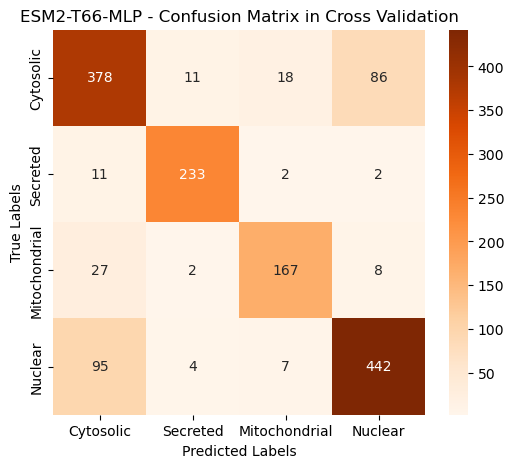

In [32]:
fold_metrics = results

# Compute confusion matrix if needed
count_matrix = fold_metrics["conf_matrices"]
# Compute confusion matrix if needed
count_matrix = count_matrix   # Take the mean over 100 epochs
count_matrix = np.round(count_matrix).astype(int)  # Round and convert to integer counts

# Define class names
class_labels = ["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"]

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(count_matrix, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("ESM2-T66-MLP - Confusion Matrix in Cross Validation")
plt.show()

## 7.6 Train on full data + Test

Compute test embeddings into a .pt file.

In [7]:
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D" )
pretrained_model = EsmModel.from_pretrained("facebook/esm2_t33_650M_UR50D" )

# Create dataset (entire training data)
dataset = ProteinDataset(test_data, labels=None, tokenizer=tokenizer, max_length=2000)

# Compute embeddinigs for the whole dataset ('train_data')
if not os.path.exists("test_esmlarge_embeddings.pt"):
    print("Computing ESM-Large embeddings for the test set...")
    compute_and_save_embeddings(
        dataset, 
        pretrained_model, 
        tokenizer, 
        save_path="test_esmlarge_embeddings.pt"
    )
    
# Load the test set precomputed embeddings
esm_test = PrecomputedEmbeddingDataset("test_esmlarge_embeddings.pt")

train_embeddings_path = "all_esmlarge_embeddings.pt"  # Full training data embeddings
test_embeddings_path = "test_esmlarge_embeddings.pt"  # Precomputed test set embeddings (no labels)

# Train on full data & generate test predictions
trained_model, (train_losses, train_accs), df_test = train_on_full_data_and_test_esm(
    train_embeddings_path=train_embeddings_path,
    test_embeddings_path=test_embeddings_path,
    batch_size=32,
    num_classes=4,
    num_epoch=100,
    lr=0.002,
    device="cuda"
)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Computing ESM-Large embeddings for the test set...
Saved embeddings to test_esmlarge_embeddings.pt


/cs/student/projects2/ml/2024/yihanli/protein-subcellular-localization-prediction/script/embedding.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(emb

In [10]:
# Show test predictions
class_mapping = {
    0: "Cytoplasm",
    1: "Secreted",
    2: "Mitochondrion",
    3: "Nucleus"
}

# Apply mapping to the 'Prediction' column
df_test["Predicted_Class"] = df_test["Prediction"].map(class_mapping)

# Define sequence identifiers manually
sequence_ids = [f"SEQ{i:02d}" for i in range(1, 21)]  # Generates ["SEQ01", "SEQ02", ..., "SEQ20"]

# Set sequence IDs as index
df_test["Sequence_ID"] = sequence_ids  # Add as a new column
df_test.set_index("Sequence_ID", inplace=True)  # Set as index

# Compute confidence scores
df_test["Max_Probability"] = df_test[["Class0_prob", "Class1_prob", "Class2_prob", "Class3_prob"]].max(axis=1)

# Define confidence level
def assign_confidence(prob):
    if prob >= 0.75:
        return "High"
    elif prob >= 0.50:
        return "Medium"
    else:
        return "Low"

df_test["Confidence"] = df_test["Max_Probability"].apply(assign_confidence)

# Show updated DataFrame
display(df_test)

# Save results to CSV
df_test.to_csv("test_predictions_ESMlarger.csv")
print("Saved test predictions.")

,Class0_prob,Class1_prob,Class2_prob,Class3_prob,Prediction,Predicted_Class,Max_Probability,Confidence
Sequence_ID,,,,,,,,
SEQ01,9.954066e-01,4.587734e-03,1.447834e-06,4.220039e-06,0,Cytoplasm,0.995407,High
SEQ02,3.445580e-01,6.978540e-02,1.008637e-02,5.755703e-01,3,Nucleus,0.575570,Medium
SEQ03,2.696752e-07,1.523576e-11,9.999998e-01,4.810053e-09,2,Mitochondrion,1.000000,High
SEQ04,9.773473e-01,2.366752e-11,2.075270e-02,1.900019e-03,0,Cytoplasm,0.977347,High
SEQ05,9.999033e-01,9.666675e-05,2.167306e-13,5.415871e-11,0,Cytoplasm,0.999903,High
SEQ06,2.132372e-14,6.799983e-14,1.000000e+00,7.291886e-09,2,Mitochondrion,1.000000,High
SEQ07,4.808746e-06,9.999952e-01,5.691738e-13,2.948060e-11,1,Secreted,0.999995,High
SEQ08,3.436973e-07,1.516042e-13,9.999983e-01,1.269859e-06,2,Mitochondrion,0.999998,High
SEQ09,1.838596e-07,9.999958e-01,6.440372e-08,3.981448e-06,1,Secreted,0.999996,High


Saved test predictions.


# Feature Analysis

In [32]:
# Define model architecture (same as training)
embedding_size = 1280  # Ensure this matches the model
num_classes = 4
device = "cuda" if T.cuda.is_available() else "cpu"

# Load trained model
trained_model = ProteinClassifier(embedding_size=embedding_size, num_classes=num_classes).to(device)
trained_model.load_state_dict(T.load("trained_esm_mlp.pth"))  # Change path if different
trained_model.eval()  # Set to evaluation mode

# Load training embeddings
train_data = T.load("all_esmlarge_embeddings.pt")
X_train = train_data["embeddings"].to(device)  # Shape: (N, 1280)
y_train = train_data["labels"].to(device)  # Shape: (N,)

/tmp/ipykernel_102877/1268861420.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(T.load("trained_esm_mlp.pth"))  # Change path if different

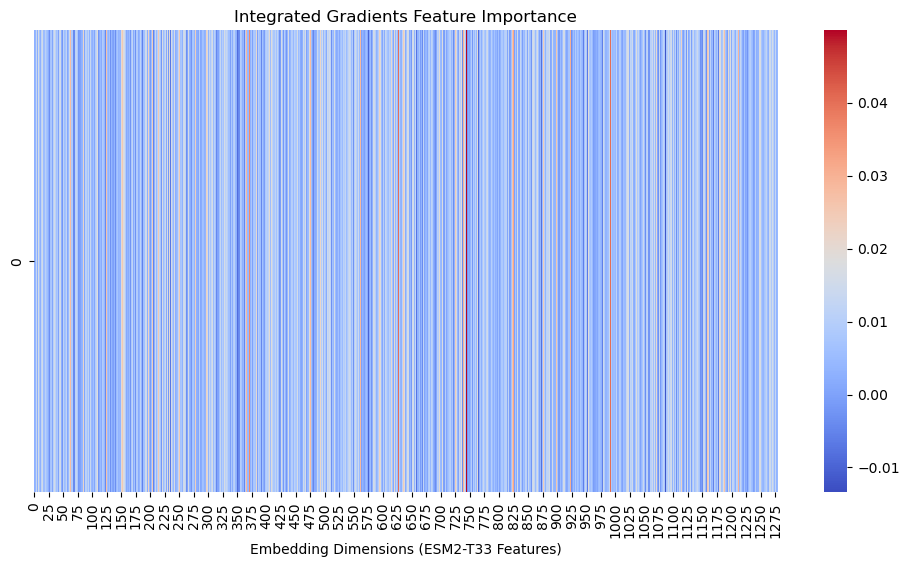

In [15]:
def model_wrapper(inputs):
    """
    Returns the logit for the predicted class for each input.
    """
    outputs = trained_model(inputs)
    # Get the predicted class indices
    pred = outputs.argmax(dim=1)
    # Gather the corresponding logits
    selected_logits = outputs[range(outputs.shape[0]), pred]
    return selected_logits

def compute_integrated_gradients(model, inputs, baseline=None):
    """
    Compute Integrated Gradients for the given inputs.
    Uses the model_wrapper to return a scalar for each input.
    """
    ig = IntegratedGradients(model_wrapper)
    if baseline is None:
        baseline = X_train.mean(dim=0, keepdim=True)  # Use mean baseline
    
    # Make sure inputs require gradients
    inputs.requires_grad = True
    # Now, since model_wrapper returns a scalar per example,
    # we do not need to pass target (or you can pass None)
    attr, convergence_delta = ig.attribute(inputs, baselines=baseline, target=None, return_convergence_delta=True)
    return attr.cpu().detach().numpy()

# Compute feature attributions using the modified function
ig_attributions = compute_integrated_gradients(trained_model, X_train)

# Plot heatmap of average feature importance
plt.figure(figsize=(12, 6))
sns.heatmap(np.mean(ig_attributions, axis=0).reshape(1, -1), cmap="coolwarm", annot=False, cbar=True)
plt.xlabel("Embedding Dimensions (ESM2-T33 Features)")
plt.title("Integrated Gradients Feature Importance")
plt.show()


Computing IG for Class 0...
Computing IG for Class 1...
Computing IG for Class 2...
Computing IG for Class 3...


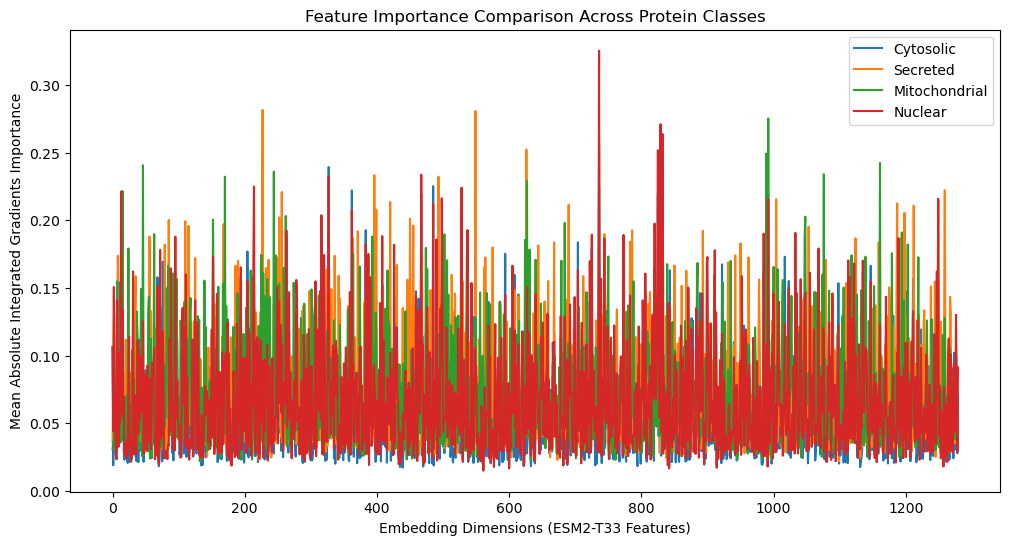

In [21]:
# Compute IG separately for each class
classwise_ig = {}

for class_idx in range(num_classes):
    print(f"Computing IG for Class {class_idx}...")
    ig = IntegratedGradients(trained_model)
    attr, _ = ig.attribute(X_train, baselines=X_train.mean(dim=0, keepdim=True),
                            target=class_idx, return_convergence_delta=True)
    
    classwise_ig[class_idx] = attr.cpu().detach().numpy()

# Convert to a structured format
classwise_ig = {k: np.mean(np.abs(v), axis=0) for k, v in classwise_ig.items()}  # Mean IG per class

# Plot comparison of feature importance across classes
plt.figure(figsize=(15, 6))
for class_idx, importance in classwise_ig.items():
    plt.plot(importance, label=f"Class {class_idx}")

plt.xlabel("Embedding Dimensions (ESM2-T33 Features)")
plt.ylabel("Mean Absolute Integrated Gradients Importance")
plt.title("Feature Importance Comparison Across Protein Classes")
plt.legend(["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"])  # Adjust labels to match class names
plt.show()

Top 10 Contributing ESM2-T33 Embedding Dimensions and Their Importance:
Rank 1: Dimension 736 | Importance Score: 0.1401
Rank 2: Dimension 829 | Importance Score: 0.1309
Rank 3: Dimension 832 | Importance Score: 0.1234
Rank 4: Dimension 825 | Importance Score: 0.1200
Rank 5: Dimension 327 | Importance Score: 0.1196
Rank 6: Dimension 467 | Importance Score: 0.1179
Rank 7: Dimension 13 | Importance Score: 0.1135
Rank 8: Dimension 528 | Importance Score: 0.1102
Rank 9: Dimension 1249 | Importance Score: 0.1095
Rank 10: Dimension 362 | Importance Score: 0.1079


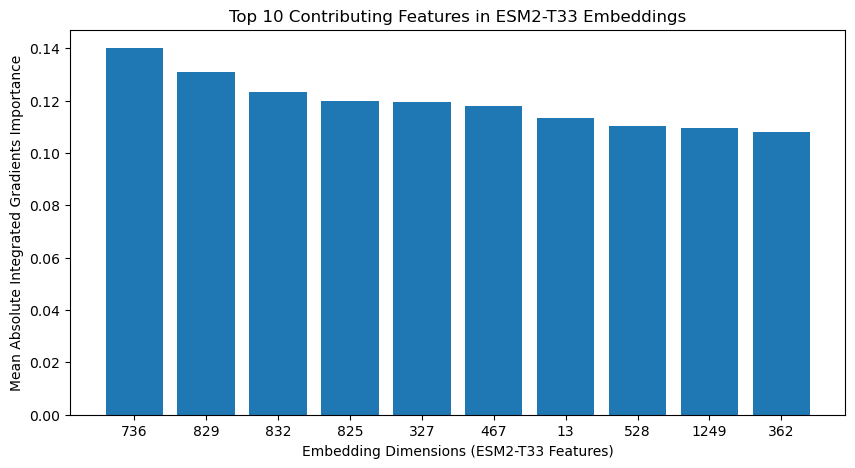

In [20]:
# Compute the mean absolute attributions across all samples
mean_importance = np.mean(np.abs(ig_attributions), axis=0)

# Get the indices of the top 10 most important features
top_dims = np.argsort(mean_importance)[::-1][:10]  # Get top 10 dimensions (descending order)

# Print the results
print("Top 10 Contributing ESM2-T33 Embedding Dimensions and Their Importance:")
for i, dim in enumerate(top_dims):
    print(f"Rank {i+1}: Dimension {dim} | Importance Score: {mean_importance[dim]:.4f}")

# Plot top feature importance
plt.figure(figsize=(10, 5))
plt.bar(range(10), mean_importance[top_dims], tick_label=top_dims)
plt.xlabel("Embedding Dimensions (ESM2-T33 Features)")
plt.ylabel("Mean Absolute Integrated Gradients Importance")
plt.title("Top 10 Contributing Features in ESM2-T33 Embeddings")
plt.show()

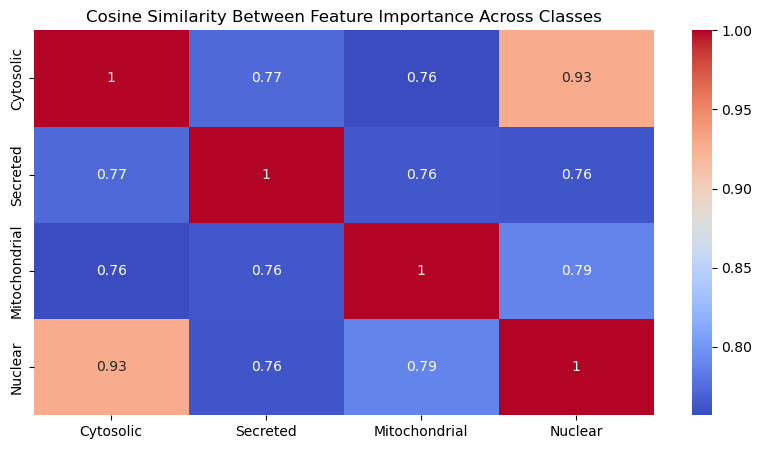

In [37]:
# Compute similarity between IG vectors for different classes
ig_vectors = np.array([classwise_ig[k] for k in range(num_classes)])  # Convert to matrix
similarity_matrix = cosine_similarity(ig_vectors)

# Plot heatmap of similarity matrix
plt.figure(figsize=(10, 5))
sns.heatmap(similarity_matrix, annot=True, cmap="coolwarm",
            xticklabels=["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"],
            yticklabels=["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"])
plt.title("Cosine Similarity Between Feature Importance Across Classes")
plt.show()


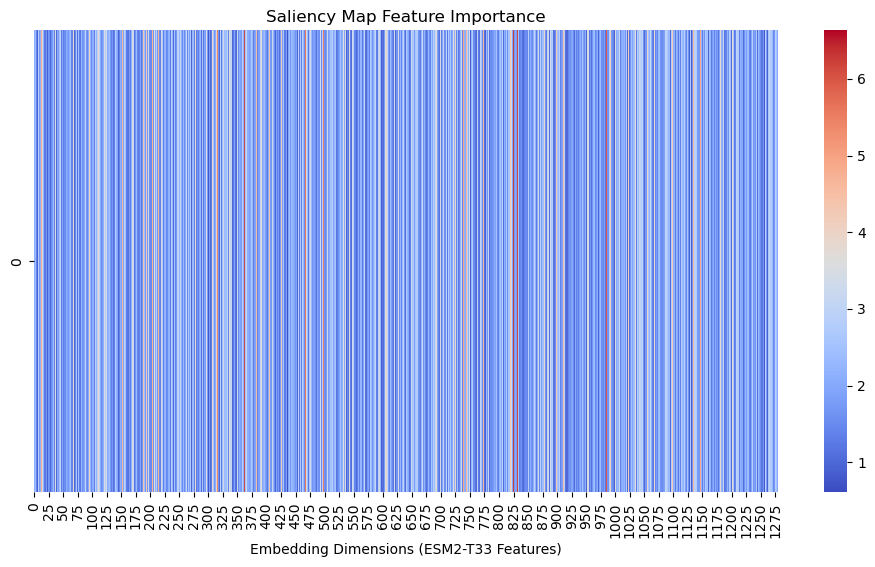

In [17]:
def compute_saliency_map(model, inputs):
    """
    Compute saliency maps for the given inputs.
    """
    saliency = Saliency(model_wrapper)
    inputs.requires_grad = True
    attr = saliency.attribute(inputs, target=None)
    return attr.cpu().detach().numpy()

# Compute saliency map
saliency_attributions = compute_saliency_map(trained_model, X_train)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(np.mean(np.abs(saliency_attributions), axis=0).reshape(1, -1), cmap="coolwarm", annot=False, cbar=True)
plt.xlabel("Embedding Dimensions (ESM2-T33 Features)")
plt.title("Saliency Map Feature Importance")
plt.show()


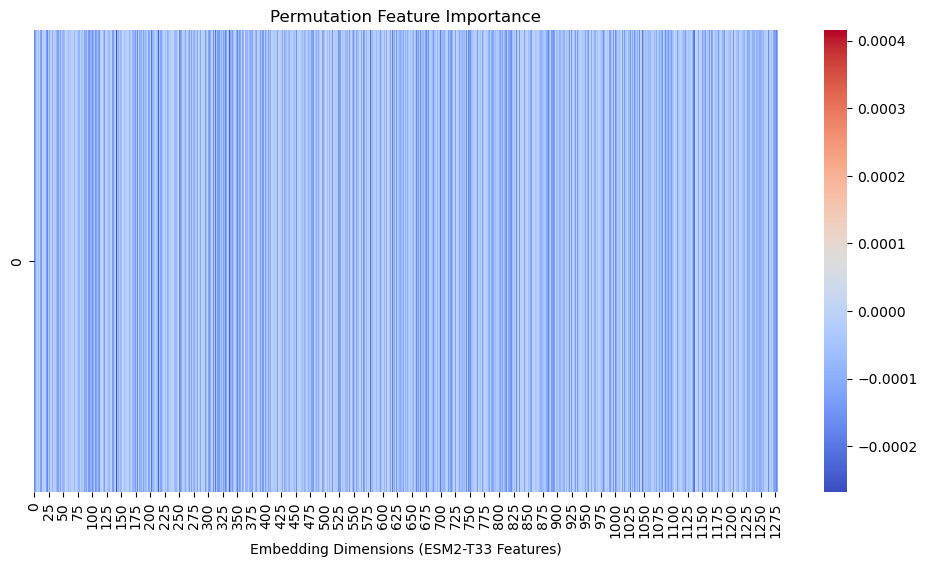

In [33]:
def compute_permutation_importance(model, X, y, num_classes=4, num_shuffles=10):
    """
    Computes permutation feature importance by shuffling each embedding dimension.
    """
    base_preds = model(X).argmax(dim=1).cpu().numpy()
    base_acc = accuracy_score(y.cpu().numpy(), base_preds)
    
    importances = np.zeros(X.shape[1])
    
    for i in range(X.shape[1]):  # Iterate over embedding dimensions
        acc_drop = []
        for _ in range(num_shuffles):
            X_perm = X.clone()
            X_perm[:, i] = X_perm[:, i][T.randperm(X.shape[0])]  # Shuffle single feature
            perm_preds = model(X_perm).argmax(dim=1).cpu().numpy()
            acc_drop.append(base_acc - accuracy_score(y.cpu().numpy(), perm_preds))
        
        importances[i] = np.mean(acc_drop)
    
    return importances

# Compute permutation importance
perm_importance = compute_permutation_importance(trained_model, X_train, y_train)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.heatmap(perm_importance.reshape(1, -1), cmap="coolwarm", annot=False, cbar=True)
plt.xlabel("Embedding Dimensions (ESM2-T33 Features)")
plt.title("Permutation Feature Importance")
plt.show()


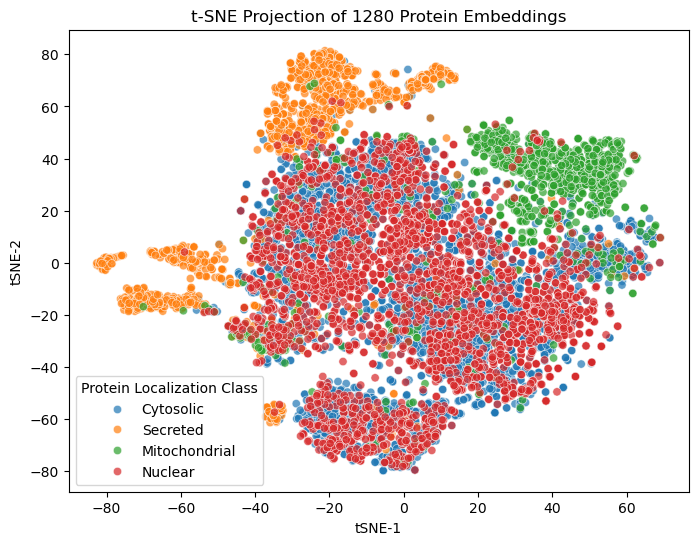

In [38]:
# Define class labels
class_labels = ["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"]

# Reduce embeddings from 1280D → 2D
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_train.cpu().numpy())

# Convert to DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=["tSNE-1", "tSNE-2"])

# Map numerical labels to class labels
df_tsne["Label"] = [class_labels[label] for label in y_train.cpu().numpy()]

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="tSNE-1", y="tSNE-2", hue="Label", palette="tab10", data=df_tsne, alpha=0.7)
plt.title("t-SNE Projection of 1280 Protein Embeddings")
plt.legend(title="Protein Localization Class")
plt.show()

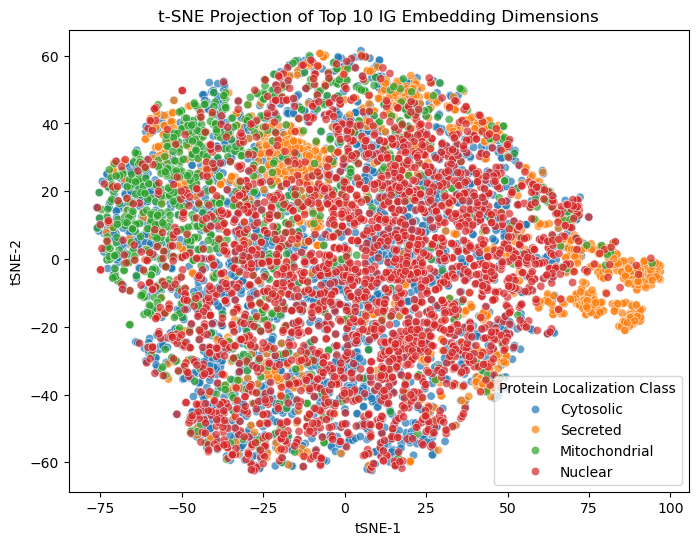

In [35]:
top_dims_list = [736, 829, 832, 825, 327, 467, 13, 528, 1249, 362]
X_top = X_train[:, top_dims_list].cpu().detach().numpy()

X_tsne_top = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_top)

df_tsne_top = pd.DataFrame(X_tsne_top, columns=["tSNE-1", "tSNE-2"])
df_tsne_top["Label"] = [class_labels[label] for label in y_train.cpu().detach().numpy()]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="tSNE-1", y="tSNE-2", hue="Label", data=df_tsne_top, alpha=0.7)
plt.title("t-SNE Projection of Top 10 IG Embedding Dimensions")
plt.legend(title="Protein Localization Class")
plt.show()

In [ ]:
#############################################
# Analyze attention for secreted proteins
#############################################

at_se, seq_se, peptides = attention_analysis(
    lstm_att_model, reverse_dict, threshold=0.05, example_idxs=[3,6,8,203]
)

# If you want the big heatmap:
att_dict, _ = lstm_att_model.attention_dict, lstm_att_model.data_att_dict  
# Then call build_secreted_heatmap (class_index='1' -> 'secreted')
build_secreted_heatmap(att_dict, class_index='0', vmax=0.03, title="Cytosolic attention")
build_secreted_heatmap(att_dict, class_index='1', vmax=0.03, title="Secreted attention")
build_secreted_heatmap(att_dict, class_index='2', vmax=0.03, title="Mitochondrial attention")
build_secreted_heatmap(att_dict, class_index='3', vmax=0.03, title="Nuclear attention")